# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups        
Sample_098  Q15768                   16.302
Sample_052  P78324;P78324-2          18.767
Sample_130  B4DGQ7;P21860;P21860-4   13.868
Sample_078  P19022                   19.433
Sample_115  Q9NSB4                   17.194
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups 
Sample_000  Q14315;Q14315-2   15.063
Sample_052  P58401            16.142
Sample_204  P12273            14.065
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.638
            A0A075B6Q5                 13.244
            A0A075B6R2                 13.455
            A0A075B6S5                 13.544
            A0A087WSY4                 13.682
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.174
            Q9UI40;Q9UI40-2            13.656
            Q9UIW2                     10.554
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.968
            Q9UP79                     13.244
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.291,15.050,16.842,19.863,15.893,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.061,19.067,...,15.528,15.576,14.486,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.880,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.209,17.705,17.039,16.136,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.615,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.048,15.345,17.084,18.708,14.249,19.433,11.917,11.361
Sample_207,15.739,16.877,15.469,16.898,14.639,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.075,13.542,13.589,12.822,13.182,13.643,12.663,12.858,11.962,12.862
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.410,19.067,16.127,...,13.529,12.715,13.332,13.403,12.863,12.217,12.616,13.193,13.524,12.575
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.925,14.151,12.234,12.210,13.506,12.656,13.672,14.588,13.601,14.048
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,14.064,13.235,12.403,12.399,11.397,13.076,12.419,13.334,13.563,14.387
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.678,13.511,12.819,13.406,14.168,12.528,12.520,13.229,12.351,12.889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.743,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 100.40it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

100%|██████████| 2/2 [00:00<00:00,  7.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.96it/s]

100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

100%|██████████| 3/3 [00:00<00:00,  6.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.01it/s]

100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.92it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.88it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.62it/s]

100%|██████████| 5/5 [00:01<00:00,  4.20it/s]

100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.39it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.54it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.24it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.23it/s]

100%|██████████| 6/6 [00:01<00:00,  4.24it/s]

100%|██████████| 6/6 [00:01<00:00,  4.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.71it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.53it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.28it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.99it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.09it/s]

100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.88it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.26it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.41it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.03it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.21it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.24it/s]

100%|██████████| 8/8 [00:01<00:00,  4.28it/s]

100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.46it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.96it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.52it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.34it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.86it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.86it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.01it/s]

100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

100%|██████████| 9/9 [00:02<00:00,  4.17it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.21it/s]

 30%|███       | 3/10 [00:00<00:01,  5.85it/s]

 40%|████      | 4/10 [00:00<00:01,  4.83it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.43it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.77it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.69it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.48it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.48it/s]

100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.29it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.59it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.75it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.18it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.91it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.80it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.47it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.53it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.66it/s]

100%|██████████| 11/11 [00:02<00:00,  3.90it/s]

100%|██████████| 11/11 [00:02<00:00,  4.06it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.43it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.74it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.13it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.43it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.47it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.36it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.20it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.14it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.04it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.16it/s]

100%|██████████| 12/12 [00:02<00:00,  4.14it/s]

100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.77it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.85it/s]

 31%|███       | 4/13 [00:01<00:02,  3.31it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.11it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.94it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.82it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.68it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.78it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.67it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.74it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.81it/s]

100%|██████████| 13/13 [00:04<00:00,  3.11it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.89it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.85it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.93it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.96it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.90it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.07it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.82it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.66it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.49it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.52it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.33it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.44it/s]

100%|██████████| 14/14 [00:03<00:00,  3.61it/s]

100%|██████████| 14/14 [00:03<00:00,  3.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.98it/s]

 20%|██        | 3/15 [00:00<00:02,  4.34it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.27it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.91it/s]

 40%|████      | 6/15 [00:01<00:03,  2.70it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.87it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.08it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.05it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.05it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.07it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.23it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.25it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.50it/s]

100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

100%|██████████| 15/15 [00:04<00:00,  3.32it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.036 0.008          0.813 0.292       0.143   
2             0.004 0.002      0.041 0.015          0.762 0.092       0.717   
3             0.004 0.002      0.039 0.009          0.770 0.113       0.723   
4             0.003 0.000      0.036 0.003          0.800 0.093       0.716   
5             0.004 0.002      0.040 0.012          0.829 0.100       0.778   
6             0.004 0.002      0.040 0.013          0.838 0.098       0.780   
7             0.004 0.004      0.046 0.017          0.838 0.097       0.779   
8             0.004 0.002      0.041 0.012          0.831 0.098       0.781   
9             0.004 0.000      0.038 0.007          0.821 0.088       0.811   
10            0.004 0.002      0.039 0.012          0.823 0.091       0.811   
11            0.005 0.004      0.039 0.012          0.816 0.094       0.799   
12            0.005 0.004      0.043 0.017          0.813 0.092       0.796   
13            0.004 0.000      0.036 0.008          0.811 0.092       0.796   
14            0.007 0.006      0.058 0.022          0.810 0.091       0.797   
15            0.006 0.007      0.058 0.025          0.807 0.094       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.236 0.123                  0.563 0.041        0.850   
2          0.102   0.733 0.074                  0.774 0.060        0.868   
3          0.105   0.739 0.083                  0.778 0.070        0.869   
4          0.114   0.749 0.079                  0.790 0.063        0.873   
5          0.093   0.800 0.080                  0.829 0.068        0.899   
6          0.096   0.804 0.078                  0.833 0.065        0.899   
7          0.096   0.803 0.077                  0.832 0.065        0.898   
8          0.104   0.801 0.083                  0.831 0.069        0.896   
9          0.100   0.812 0.073                  0.839 0.062        0.911   
10         0.099   0.812 0.072                  0.839 0.061        0.911   
11         0.108   0.803 0.079                  0.832 0.066        0.908   
12         0.108   0.800 0.078                  0.829 0.066        0.908   
13         0.107   0.799 0.079                  0.828 0.067        0.905   
14         0.109   0.799 0.080                  0.829 0.068        0.904   
15         0.107   0.797 0.079                  0.826 0.067        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.821 0.088        210.000 0.000  
2          0.060                  0.840 0.083        210.000 0.000  
3          0.066                  0.845 0.083        210.000 0.000  
4          0.064                  0.849 0.075        210.000 0.000  
5          0.056                  0.890 0.061        210.000 0.000  
6          0.055                  0.889 0.060        210.000 0.000  
7          0.057                  0.888 0.062        210.000 0.000  
8          0.057                  0.887 0.062        210.000 0.000  
9          0.052                  0.900 0.054        210.000 0.000  
10         0.053                  0.901 0.054        210.000 0.000  
11         0.055                  0.896 0.058        210.000 0.000  
12         0.055                  0.896 0.057        210.000 0.000  
13         0.055                  0.894 0.056        210.000 0.000  
14         0.055                  0.893 0.056        210.000 0.000  
15         0.055                  0.891 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 501.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.14it/s]

100%|██████████| 3/3 [00:00<00:00,  4.26it/s]

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.73it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.61it/s]

100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.00it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.60it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

100%|██████████| 5/5 [00:01<00:00,  3.13it/s]

100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.11it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.62it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.25it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.95it/s]

100%|██████████| 6/6 [00:01<00:00,  2.73it/s]

100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.47it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.17it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.83it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.51it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.62it/s]

100%|██████████| 7/7 [00:01<00:00,  3.14it/s]

100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.61it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.50it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.70it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.37it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.53it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.43it/s]

100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.81it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.29it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.70it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.42it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.45it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.14it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.20it/s]

100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.52it/s]

 30%|███       | 3/10 [00:00<00:01,  4.08it/s]

 40%|████      | 4/10 [00:01<00:01,  3.51it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.35it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.30it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.43it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.40it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.31it/s]

100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.72it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.24it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.51it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.14it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.34it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.52it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.54it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.56it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.52it/s]

100%|██████████| 11/11 [00:03<00:00,  3.52it/s]

100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.71it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.16it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.59it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.52it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.50it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.59it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.66it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.57it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.40it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.40it/s]

100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.41it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.48it/s]

 31%|███       | 4/13 [00:01<00:03,  2.82it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.66it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.89it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.89it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.00it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.07it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.21it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.23it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.33it/s]

100%|██████████| 13/13 [00:04<00:00,  2.90it/s]

100%|██████████| 13/13 [00:04<00:00,  3.06it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.69it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.87it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.73it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.11it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.76it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.60it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.53it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.69it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.80it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.09it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.14it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.20it/s]

100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

100%|██████████| 14/14 [00:04<00:00,  3.04it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.75it/s]

 20%|██        | 3/15 [00:00<00:03,  3.68it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.44it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.29it/s]

 40%|████      | 6/15 [00:01<00:02,  3.29it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.25it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.45it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.46it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.53it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.61it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.66it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.08it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.94it/s]

100%|██████████| 15/15 [00:04<00:00,  2.82it/s]

100%|██████████| 15/15 [00:04<00:00,  3.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.053 0.027          0.087 0.248       0.009   
2             0.004 0.001      0.043 0.014          0.640 0.159       0.339   
3             0.005 0.004      0.051 0.018          0.635 0.149       0.433   
4             0.006 0.006      0.056 0.019          0.816 0.095       0.646   
5             0.005 0.004      0.059 0.023          0.773 0.094       0.650   
6             0.006 0.005      0.056 0.021          0.781 0.099       0.666   
7             0.005 0.004      0.058 0.024          0.769 0.095       0.657   
8             0.004 0.003      0.049 0.020          0.835 0.082       0.800   
9             0.006 0.005      0.064 0.025          0.825 0.083       0.799   
10            0.006 0.005      0.066 0.024          0.816 0.083       0.794   
11            0.006 0.004      0.075 0.021          0.812 0.086       0.793   
12            0.007 0.006      0.070 0.026          0.816 0.088       0.798   
13            0.008 0.007      0.072 0.030          0.821 0.089       0.790   
14            0.006 0.006      0.057 0.022          0.851 0.079       0.817   
15            0.006 0.005      0.052 0.021          0.847 0.078       0.818   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.867   
2          0.118   0.426 0.103                  0.591 0.057        0.697   
3          0.120   0.506 0.115                  0.621 0.077        0.674   
4          0.112   0.715 0.090                  0.768 0.064        0.820   
5          0.117   0.700 0.092                  0.753 0.067        0.813   
6          0.111   0.713 0.089                  0.763 0.067        0.815   
7          0.120   0.702 0.092                  0.755 0.067        0.814   
8          0.101   0.813 0.069                  0.841 0.057        0.901   
9          0.102   0.807 0.071                  0.836 0.059        0.899   
10         0.109   0.800 0.075                  0.831 0.061        0.918   
11         0.112   0.797 0.074                  0.828 0.061        0.915   
12         0.114   0.801 0.079                  0.832 0.067        0.916   
13         0.111   0.799 0.076                  0.830 0.063        0.918   
14         0.109   0.829 0.074                  0.855 0.061        0.927   
15         0.099   0.828 0.069                  0.854 0.058        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.836 0.088        210.000 0.000  
2          0.090                  0.609 0.106        210.000 0.000  
3          0.076                  0.628 0.091        210.000 0.000  
4          0.067                  0.806 0.084        210.000 0.000  
5          0.068                  0.794 0.085        210.000 0.000  
6          0.070                  0.795 0.089        210.000 0.000  
7          0.071                  0.791 0.089        210.000 0.000  
8          0.051                  0.887 0.056        210.000 0.000  
9          0.051                  0.885 0.057        210.000 0.000  
10         0.045                  0.898 0.054        210.000 0.000  
11         0.047                  0.895 0.055        210.000 0.000  
12         0.045                  0.895 0.054        210.000 0.000  
13         0.045                  0.897 0.055        210.000 0.000  
14         0.043                  0.911 0.049        210.000 0.000  
15         0.042                  0.912 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1092.84it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 27.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.99it/s]

100%|██████████| 3/3 [00:00<00:00, 16.77it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.40it/s]

100%|██████████| 4/4 [00:00<00:00, 15.68it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.40it/s]

100%|██████████| 5/5 [00:00<00:00, 19.12it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.39it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.23it/s]

100%|██████████| 6/6 [00:00<00:00, 14.45it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.70it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.95it/s]

100%|██████████| 7/7 [00:00<00:00, 17.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.91it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.77it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.89it/s]

100%|██████████| 8/8 [00:00<00:00, 13.43it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.97it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.69it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.06it/s]

100%|██████████| 9/9 [00:00<00:00, 13.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.45it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.97it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.88it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.27it/s]

100%|██████████| 10/10 [00:00<00:00, 13.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.15it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.96it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 15.33it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 15.10it/s]

100%|██████████| 11/11 [00:00<00:00, 14.05it/s]

100%|██████████| 11/11 [00:00<00:00, 14.70it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.55it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.52it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.57it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.85it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.74it/s]

100%|██████████| 12/12 [00:00<00:00, 14.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.04it/s]

 46%|████▌     | 6/13 [00:00<00:00, 14.41it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.07it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.82it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 11.74it/s]

100%|██████████| 13/13 [00:01<00:00, 12.48it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.72it/s]

 43%|████▎     | 6/14 [00:00<00:00, 14.57it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.31it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.89it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.72it/s]

100%|██████████| 14/14 [00:01<00:00, 11.92it/s]

100%|██████████| 14/14 [00:01<00:00, 13.22it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.14it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.67it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.16it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.86it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.64it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.37it/s]

100%|██████████| 15/15 [00:01<00:00, 12.55it/s]

100%|██████████| 15/15 [00:01<00:00, 12.94it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.042 0.012          0.000 0.000       0.000   
2             0.004 0.003      0.046 0.018          0.628 0.075       0.585   
3             0.004 0.004      0.041 0.014          0.702 0.064       0.635   
4             0.004 0.003      0.044 0.014          0.683 0.080       0.626   
5             0.004 0.002      0.044 0.017          0.696 0.082       0.614   
6             0.007 0.007      0.082 0.027          0.708 0.080       0.617   
7             0.006 0.005      0.061 0.021          0.697 0.093       0.629   
8             0.004 0.002      0.041 0.011          0.681 0.086       0.629   
9             0.007 0.006      0.063 0.026          0.686 0.086       0.632   
10            0.006 0.005      0.061 0.032          0.691 0.088       0.657   
11            0.007 0.006      0.069 0.026          0.702 0.084       0.670   
12            0.004 0.002      0.042 0.013          0.698 0.088       0.664   
13            0.006 0.005      0.067 0.030          0.681 0.084       0.646   
14            0.006 0.006      0.062 0.031          0.691 0.082       0.678   
15            0.008 0.007      0.066 0.039          0.684 0.083       0.670   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.740   
2          0.117   0.603 0.092                  0.669 0.068        0.754   
3          0.098   0.664 0.073                  0.720 0.056        0.795   
4          0.106   0.649 0.081                  0.706 0.062        0.802   
5          0.111   0.648 0.085                  0.709 0.064        0.808   
6          0.112   0.655 0.087                  0.716 0.062        0.808   
7          0.118   0.656 0.095                  0.714 0.070        0.815   
8          0.112   0.650 0.089                  0.707 0.066        0.813   
9          0.112   0.654 0.090                  0.711 0.068        0.809   
10         0.110   0.669 0.087                  0.721 0.067        0.816   
11         0.114   0.681 0.086                  0.731 0.067        0.819   
12         0.119   0.676 0.091                  0.727 0.070        0.816   
13         0.120   0.659 0.093                  0.713 0.071        0.820   
14         0.117   0.680 0.089                  0.729 0.070        0.825   
15         0.119   0.673 0.091                  0.723 0.071        0.823   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.674 0.080        210.000 0.000  
2          0.052                  0.690 0.065        210.000 0.000  
3          0.053                  0.723 0.074        210.000 0.000  
4          0.056                  0.734 0.069        210.000 0.000  
5          0.061                  0.751 0.078        210.000 0.000  
6          0.058                  0.757 0.074        210.000 0.000  
7          0.056                  0.769 0.068        210.000 0.000  
8          0.059                  0.767 0.069        210.000 0.000  
9          0.059                  0.756 0.074        210.000 0.000  
10         0.058                  0.761 0.079        210.000 0.000  
11         0.062                  0.766 0.085        210.000 0.000  
12         0.063                  0.762 0.084        210.000 0.000  
13         0.061                  0.769 0.079        210.000 0.000  
14         0.059                  0.776 0.073        210.000 0.000  
15         0.059                  0.774 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,13,15
score_time,15,11,6
test_precision,7,14,6
test_recall,9,15,14
test_f1,10,14,11
test_balanced_accuracy,10,14,11
test_roc_auc,10,14,14
test_average_precision,10,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.26it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.57it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.87it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.40it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.01it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.10it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.14it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.59it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.24it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.99it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.93it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.74it/s]

100%|██████████| 14/14 [00:05<00:00,  1.76it/s]

100%|██████████| 14/14 [00:05<00:00,  2.38it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 14.60it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.26it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.26it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.49it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.06it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.32it/s]

100%|██████████| 14/14 [00:01<00:00, 11.28it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.52it/s]

 30%|███       | 3/10 [00:00<00:01,  5.05it/s]

 40%|████      | 4/10 [00:00<00:01,  4.28it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.91it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.77it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.77it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.86it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.41it/s]

100%|██████████| 10/10 [00:02<00:00,  2.88it/s]

100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


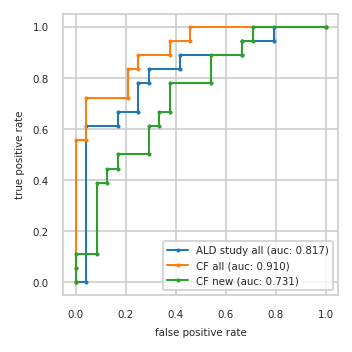

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.611  0.000 0.556  0.000 0.111
3          0.167 0.611  0.042 0.556  0.083 0.111
4          0.167 0.667  0.042 0.722  0.083 0.389
5          0.250 0.667  0.208 0.722  0.125 0.389
6          0.250 0.778  0.208 0.833  0.125 0.444
7          0.292 0.778  0.250 0.833  0.167 0.444
8          0.292 0.833  0.250 0.889  0.167 0.500
9          0.417 0.833  0.375 0.889  0.292 0.500
10         0.417 0.889  0.375 0.944  0.292 0.611
11         0.667 0.889  0.458 0.944  0.333 0.611
12         0.667 0.944  0.458 1.000  0.333 0.667
13         0.792 0.944  1.000 1.000  0.375 0.667
14         0.792 1.000    NaN   NaN  0.375 0.778
15         1.000 1.000    NaN   NaN  0.542 0.778
16           NaN   NaN    NaN   NaN  0.542 0.889
17           NaN   NaN    NaN   NaN  0.667 0.889
18           NaN   NaN    NaN   NaN  0.667 0.944
19           NaN   NaN    NaN   NaN  0.708 0.944
20           NaN   NaN    NaN   NaN  0.708 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q15848,B7Z2R4;C9JR67;O43556;O43556-3;O43556-4,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
2,G3XAP6;P49747;P49747-2,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,Q96GD0
3,P61981,P14174,P31150
4,Q99983,Q14894,P31321
5,P04075,P61981,O95497
6,P14174,Q9Y2T3;Q9Y2T3-3,B7Z5R6;Q14596;Q14596-2
7,Q9Y2T3;Q9Y2T3-3,P04075,A0A075B7B8
8,P00338;P00338-3,P63104,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


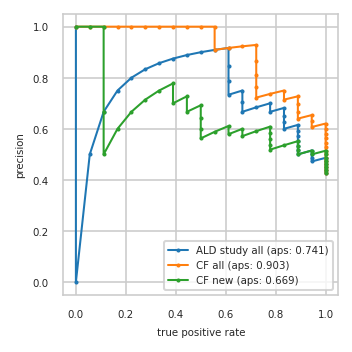

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.500 0.889     0.562 1.000     0.500 0.889
11         0.516 0.889     0.581 1.000     0.516 0.889
12         0.533 0.889     0.600 1.000     0.533 0.889
13         0.552 0.889     0.621 1.000     0.552 0.889
14         0.571 0.889     0.607 0.944     0.536 0.833
15         0.593 0.889     0.630 0.944     0.519 0.778
16         0.615 0.889     0.654 0.944     0.538 0.778
17         0.600 0.833     0.640 0.889     0.560 0.778
18         0.625 0.833     0.667 0.889     0.583 0.778
19         0.652 0.833     0.696 0.889     0.609 0.778
20         0.682 0.833     0.727 0.889     0.591 0.722
21         0.667 0.778     0.714 0.833     0.571 0.667
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.684 0.722     0.737 0.778     0.579 0.611
24         0.667 0.667     0.722 0.722     0.611 0.611
25         0.706 0.667     0.765 0.722     0.588 0.556
26         0.750 0.667     0.812 0.722     0.562 0.500
27         0.733 0.611     0.867 0.722     0.600 0.500
28         0.786 0.611     0.929 0.722     0.643 0.500
29         0.846 0.611     0.923 0.667     0.692 0.500
30         0.917 0.611     0.917 0.611     0.667 0.444
31         0.909 0.556     0.909 0.556     0.727 0.444
32         0.900 0.500     1.000 0.556     0.700 0.389
33         0.889 0.444     1.000 0.500     0.778 0.389
34         0.875 0.389     1.000 0.444     0.750 0.333
35         0.857 0.333     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


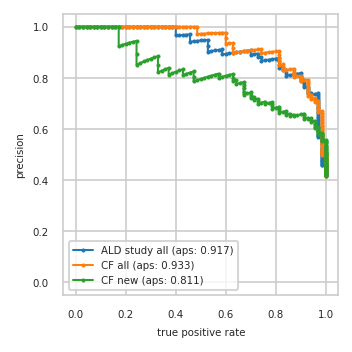

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


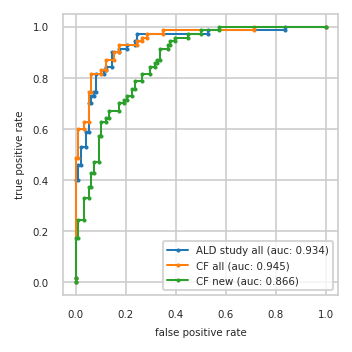

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}